In [47]:
!pip install pytorch-ignite==0.2.* tensorboardX==1.6.*
import os
import numpy as np
import random
import torch
import ignite

seed = 17
random.seed(seed)
_ = torch.manual_seed(seed)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
torch.__version__, ignite.__version__

('1.12.1+cu113', '0.2.1')

In [49]:
import torch
import torch.nn as nn

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class Flatten(nn.Module):
    def forward(self, x):
        return x.reshape(x.shape[0], -1)

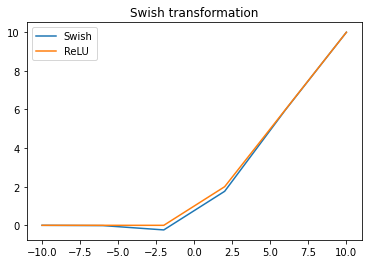

In [50]:
import matplotlib.pylab as plt
%matplotlib inline

d = torch.linspace(-10.0, 10.0, steps=6)
s = Swish()
res = s(d)
res2 = torch.relu(d)

plt.title("Swish transformation")
plt.plot(d.numpy(), res.numpy(), label='Swish')
plt.plot(d.numpy(), res2.numpy(), label='ReLU')
plt.legend()

In [51]:
class SqueezeExcitation(nn.Module):
    
    def __init__(self, inplanes, se_planes):
        super(SqueezeExcitation, self).__init__()
        self.reduce_expand = nn.Sequential(
            nn.Conv2d(inplanes, se_planes, 
                      kernel_size=1, stride=1, padding=0, bias=True),
            Swish(),
            nn.Conv2d(se_planes, inplanes, 
                      kernel_size=1, stride=1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_se = torch.mean(x, dim=(-2, -1), keepdim=True)
        x_se = self.reduce_expand(x_se)
        return x_se * x

In [52]:
from torch.nn import functional as F

class MBConv(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, stride, 
                 expand_rate=1.0, se_rate=0.25, 
                 drop_connect_rate=0.2):
        super(MBConv, self).__init__()

        expand_planes = int(inplanes * expand_rate)
        se_planes = max(1, int(inplanes * se_rate))

        self.expansion_conv = None        
        if expand_rate > 1.0:
            self.expansion_conv = nn.Sequential(
                nn.Conv2d(inplanes, expand_planes, 
                          kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(expand_planes, momentum=0.01, eps=1e-3),
                Swish()
            )
            inplanes = expand_planes

        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(inplanes, expand_planes,
                      kernel_size=kernel_size, stride=stride, 
                      padding=kernel_size // 2, groups=expand_planes,
                      bias=False),
            nn.BatchNorm2d(expand_planes, momentum=0.01, eps=1e-3),
            Swish()
        )

        self.squeeze_excitation = SqueezeExcitation(expand_planes, se_planes)
        
        self.project_conv = nn.Sequential(
            nn.Conv2d(expand_planes, planes, 
                      kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(planes, momentum=0.01, eps=1e-3),
        )

        self.with_skip = stride == 1
        self.drop_connect_rate = torch.tensor(drop_connect_rate, requires_grad=False)
    
    def _drop_connect(self, x):        
        keep_prob = 1.0 - self.drop_connect_rate
        drop_mask = torch.rand(x.shape[0], 1, 1, 1) + keep_prob
        drop_mask = drop_mask.type_as(x)
        drop_mask.floor_()
        return drop_mask * x / keep_prob
        
    def forward(self, x):
        z = x
        if self.expansion_conv is not None:
            x = self.expansion_conv(x)

        x = self.depthwise_conv(x)
        x = self.squeeze_excitation(x)
        x = self.project_conv(x)
        
        # Add identity skip
        if x.shape == z.shape and self.with_skip:            
            if self.training and self.drop_connect_rate is not None:
                self._drop_connect(x)
            x += z
        return x

In [53]:
from collections import OrderedDict
import math


def init_weights(module):    
    if isinstance(module, nn.Conv2d):    
        nn.init.kaiming_normal_(module.weight, a=0, mode='fan_out')
    elif isinstance(module, nn.Linear):
        init_range = 1.0 / math.sqrt(module.weight.shape[1])
        nn.init.uniform_(module.weight, a=-init_range, b=init_range)
        
        
class EfficientNet(nn.Module):
        
    def _setup_repeats(self, num_repeats):
        return int(math.ceil(self.depth_coefficient * num_repeats))
    
    def _setup_channels(self, num_channels):
        num_channels *= self.width_coefficient
        new_num_channels = math.floor(num_channels / self.divisor + 0.5) * self.divisor
        new_num_channels = max(self.divisor, new_num_channels)
        if new_num_channels < 0.9 * num_channels:
            new_num_channels += self.divisor
        return new_num_channels

    def __init__(self, num_classes=10, 
                 width_coefficient=1.0,
                 depth_coefficient=1.0,
                 se_rate=0.25,
                 dropout_rate=0.2,
                 drop_connect_rate=0.2):
        super(EfficientNet, self).__init__()
        
        self.width_coefficient = width_coefficient
        self.depth_coefficient = depth_coefficient
        self.divisor = 8
                
        list_channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
        list_channels = [self._setup_channels(c) for c in list_channels]
                
        list_num_repeats = [1, 2, 2, 3, 3, 4, 1]
        list_num_repeats = [self._setup_repeats(r) for r in list_num_repeats]        
        
        expand_rates = [1, 6, 6, 6, 6, 6, 6]
        strides = [1, 2, 2, 2, 1, 2, 1]
        kernel_sizes = [3, 3, 5, 3, 5, 5, 3]

        # Define stem:
        self.stem = nn.Sequential(
            nn.Conv2d(3, list_channels[0], kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(list_channels[0], momentum=0.01, eps=1e-3),
            Swish()
        )
        
        # Define MBConv blocks
        blocks = []
        counter = 0
        num_blocks = sum(list_num_repeats)
        for idx in range(7):
            
            num_channels = list_channels[idx]
            next_num_channels = list_channels[idx + 1]
            num_repeats = list_num_repeats[idx]
            expand_rate = expand_rates[idx]
            kernel_size = kernel_sizes[idx]
            stride = strides[idx]
            drop_rate = drop_connect_rate * counter / num_blocks
            
            name = "MBConv{}_{}".format(expand_rate, counter)
            blocks.append((
                name,
                MBConv(num_channels, next_num_channels, 
                       kernel_size=kernel_size, stride=stride, expand_rate=expand_rate, 
                       se_rate=se_rate, drop_connect_rate=drop_rate)
            ))
            counter += 1
            for i in range(1, num_repeats):                
                name = "MBConv{}_{}".format(expand_rate, counter)
                drop_rate = drop_connect_rate * counter / num_blocks                
                blocks.append((
                    name,
                    MBConv(next_num_channels, next_num_channels, 
                           kernel_size=kernel_size, stride=1, expand_rate=expand_rate, 
                           se_rate=se_rate, drop_connect_rate=drop_rate)                                    
                ))
                counter += 1
        
        self.blocks = nn.Sequential(OrderedDict(blocks))
        
        # Define head
        self.head = nn.Sequential(
            nn.Conv2d(list_channels[-2], list_channels[-1], 
                      kernel_size=1, bias=False),
            nn.BatchNorm2d(list_channels[-1], momentum=0.01, eps=1e-3),
            Swish(),
            nn.AdaptiveAvgPool2d(1),
            Flatten(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(list_channels[-1], num_classes)
        )

        self.apply(init_weights)
        
    def forward(self, x):
        f = self.stem(x)
        f = self.blocks(f)
        y = self.head(f)
        return y

In [54]:
model = EfficientNet(num_classes=1000, 
                     width_coefficient=1.0, depth_coefficient=1.0, 
                     dropout_rate=0.2)

In [55]:
def print_num_params(model, display_all_modules=False):
    total_num_params = 0
    for n, p in model.named_parameters():
        num_params = 1
        for s in p.shape:
            num_params *= s
        if display_all_modules: print("{}: {}".format(n, num_params))
        total_num_params += num_params
    print("-" * 50)
    print("Total number of parameters: {:.2e}".format(total_num_params))
    

print_num_params(model)

--------------------------------------------------
Total number of parameters: 5.29e+06


In [56]:
from torchvision.models.resnet import resnet18, resnet34, resnet50

In [57]:
print_num_params(resnet18(pretrained=False, num_classes=10))
print_num_params(resnet34(pretrained=False, num_classes=10))
print_num_params(resnet50(pretrained=False, num_classes=10))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


--------------------------------------------------
Total number of parameters: 1.12e+07
--------------------------------------------------
Total number of parameters: 2.13e+07
--------------------------------------------------
Total number of parameters: 2.35e+07


In [58]:
from tensorboardX.pytorch_graph import graph

import random
from IPython.display import clear_output, Image, display, HTML


def show_graph(graph_def):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = graph_def
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(random.randint(0, 1000)))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [59]:
!wget http://storage.googleapis.com/public-models/efficientnet-b0-08094119.pth

--2022-11-18 04:21:36--  http://storage.googleapis.com/public-models/efficientnet-b0-08094119.pth
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21383481 (20M) [application/octet-stream]
Saving to: ‘efficientnet-b0-08094119.pth.2’

efficientnet-b0-080 100%[===================>]  20.39M  10.7MB/s    in 1.9s    

2022-11-18 04:21:39 (10.7 MB/s) - ‘efficientnet-b0-08094119.pth.2’ saved [21383481/21383481]



In [60]:
from collections import OrderedDict

model_state = torch.load("efficientnet-b0-08094119.pth")

# A basic remapping is required
mapping = {
    k: v for k, v in zip(model_state.keys(), model.state_dict().keys())
}
mapped_model_state = OrderedDict([
    (mapping[k], v) for k, v in model_state.items()
])

model.load_state_dict(mapped_model_state, strict=False)

<All keys matched successfully>

In [61]:
!wget https://raw.githubusercontent.com/lukemelas/EfficientNet-PyTorch/master/examples/simple/img.jpg -O/tmp/giant_panda.jpg
!wget https://raw.githubusercontent.com/lukemelas/EfficientNet-PyTorch/master/examples/simple/labels_map.txt -O/tmp/labels_map.txt

--2022-11-18 04:21:39--  https://raw.githubusercontent.com/lukemelas/EfficientNet-PyTorch/master/examples/simple/img.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116068 (113K) [image/jpeg]
Saving to: ‘/tmp/giant_panda.jpg’

/tmp/giant_panda.jp 100%[===================>] 113.35K  --.-KB/s    in 0.004s  

2022-11-18 04:21:40 (30.5 MB/s) - ‘/tmp/giant_panda.jpg’ saved [116068/116068]

--2022-11-18 04:21:40--  https://raw.githubusercontent.com/lukemelas/EfficientNet-PyTorch/master/examples/simple/labels_map.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awai

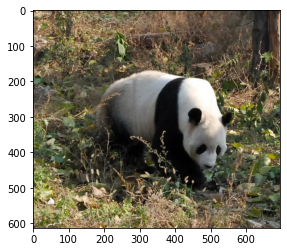

In [62]:
import json

with open("/tmp/labels_map.txt", "r") as h:
    labels = json.load(h)

from PIL import Image
import torchvision.transforms as transforms


img = Image.open("/tmp/giant_panda.jpg")
# Preprocess image
tfms = transforms.Compose([transforms.Resize(224),
                           transforms.ToTensor(),
                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
x = tfms(img).unsqueeze(0)
_ = plt.imshow(img)


In [63]:
model.eval()
with torch.no_grad():
    y_pred = model(x)

# Print predictions
print('-----')
for idx in torch.topk(y_pred, k=5)[1].squeeze(0).tolist():
    prob = torch.softmax(y_pred, dim=1)[0, idx].item()
    print('{label:<75} ({p:.2f}%)'.format(label=labels[str(idx)], p=prob*100))

-----
giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca           (90.70%)
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus                 (0.39%)
kuvasz                                                                      (0.20%)
Staffordshire bullterrier, Staffordshire bull terrier                       (0.17%)
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens         (0.17%)


In [64]:
#from torchvision.datasets.cifar import CIFAR100, CIFAR10
from torchvision.datasets import CIFAR100
from torchvision.datasets import CIFAR10

from torchvision.transforms import Compose, RandomCrop, Pad, RandomHorizontalFlip, Resize, RandomAffine
from torchvision.transforms import ToTensor, Normalize

from torch.utils.data import Subset
import torchvision.utils as vutils

In [65]:
       
# train_dataset = CIFAR100(root='data/', download=True, transform=train_transform)
# val_dataset = CIFAR100(root='data/', train=False, transform=val_transform)




In [66]:
from PIL.Image import BICUBIC

path = "."
image_size = 224

train_transform = Compose([
    Resize(image_size, BICUBIC),
    RandomAffine(degrees=2, translate=(0.02, 0.02), scale=(0.98, 1.02), shear=2, fillcolor=(124,117,104)),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = Compose([
    Resize(image_size, BICUBIC),    
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = CIFAR100(root='data/', download=True, transform=train_transform)
test_dataset = CIFAR100(root='data/', train=False, transform=test_transform)

#train_dataset = CIFAR10(root='data/', download=True, transform=train_transform)
#test_dataset = CIFAR10(root='data/', train=False, transform=test_transform)

train_eval_indices = [random.randint(0, len(train_dataset) - 1) for i in range(len(test_dataset))]
train_eval_dataset = Subset(train_dataset, train_eval_indices)

len(train_dataset), len(test_dataset), len(train_eval_dataset)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1443: UserWarning: The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. Please use 'fill' instead.
  "The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. "


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/


(50000, 10000, 10000)

In [67]:
from torch.utils.data import DataLoader

batch_size = 96
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, 
                          shuffle=True, drop_last=True, pin_memory=True)

test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, 
                         shuffle=False, drop_last=False, pin_memory=True)

eval_train_loader = DataLoader(train_eval_dataset, batch_size=batch_size, num_workers=num_workers, 
                               shuffle=False, drop_last=False, pin_memory=True)

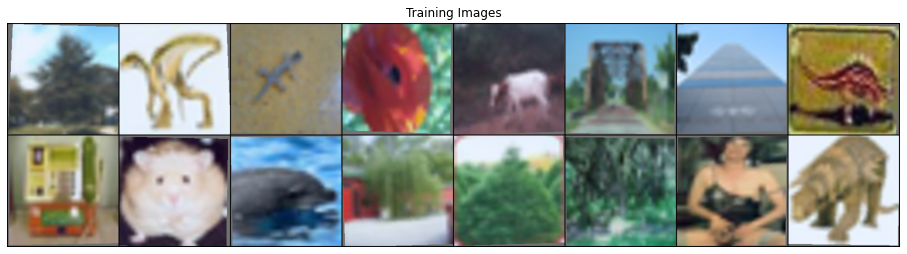

In [68]:
batch = next(iter(train_loader))

plt.figure(figsize=(16, 8))
plt.axis("off")
plt.title("Training Images")
_ = plt.imshow( 
    vutils.make_grid(batch[0][:16], padding=2, normalize=True).cpu().numpy().transpose((1, 2, 0))
)


In [69]:
model.eval()
with torch.no_grad():
    y_pred = model(batch[0][:1])

# Print predictions
print('-----')
for idx in torch.topk(y_pred, k=9)[1].squeeze(0).tolist():
    prob = torch.softmax(y_pred, dim=1)[0, idx].item()
    print('{label:<75} ({p:.2f}%)'.format(label=labels[str(idx)], p=prob*100))

-----
window screen                                                               (26.54%)
shoji                                                                       (11.26%)
window shade                                                                (8.90%)
monitor                                                                     (6.30%)
sliding door                                                                (2.93%)
bannister, banister, balustrade, balusters, handrail                        (2.50%)
scoreboard                                                                  (2.46%)
television, television system                                               (2.42%)
prison, prison house                                                        (1.64%)


In [70]:
batch = None
torch.cuda.empty_cache()

In [71]:
model.head[6].in_features, model.head[6].out_features

(1280, 1000)

In [72]:
model.head[6] = nn.Linear(1280, 100)
c10classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [73]:
model.head[6].in_features, model.head[6].out_features

(1280, 100)

In [74]:
assert torch.cuda.is_available()
assert torch.backends.cudnn.enabled, "NVIDIA/Apex:Amp requires cudnn backend to be enabled."
torch.backends.cudnn.benchmark = True

device = "cuda"

In [75]:
model = model.to(device)

In [76]:
from itertools import chain

import torch.optim as optim
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
lr = 0.01

optimizer = optim.SGD([
    {
        "params": chain(model.stem.parameters(), model.blocks.parameters()),
        "lr": lr * 0.1,
    },
    {
        "params": model.head[:6].parameters(),
        "lr": lr * 0.2,
    },    
    {
        "params": model.head[6].parameters(), 
        "lr": lr
    }], 
    momentum=0.9, weight_decay=1e-3, nesterov=True)

In [77]:
from torch.optim.lr_scheduler import ExponentialLR
lr_scheduler = ExponentialLR(optimizer, gamma=0.975)

In [78]:
!pip install apex
!pip install AMP

use_amp = False

if use_amp:
    try:
        from apex import amp
    except ImportError:
        !git clone https://github.com/NVIDIA/apex
        !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" apex/
        from apex import amp


    # Initialize Amp
    model, optimizer = amp.initialize(model, optimizer, opt_level="O2", num_losses=1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
from ignite.utils import convert_tensor

use_amp = False
def update_fn(engine, batch):
    model.train()

    x = convert_tensor(batch[0], device=device, non_blocking=True)
    y = convert_tensor(batch[1], device=device, non_blocking=True)
    
    y_pred = model(x)
    
    # Compute loss 
    loss = criterion(y_pred, y)    

    optimizer.zero_grad()
    if use_amp:
        with amp.scale_loss(loss, optimizer, loss_id=0) as scaled_loss:
            scaled_loss.backward()
    else:
        loss.backward()
    optimizer.step()
    
    return {
        "batchloss": loss.item(),
    }    

In [80]:
batch = next(iter(train_loader))

res = update_fn(engine=None, batch=batch)

batch = None
torch.cuda.empty_cache()

res

{'batchloss': 4.646604061126709}

In [81]:
from ignite.engine import Engine, Events, create_supervised_evaluator
from ignite.metrics import RunningAverage, Accuracy, Precision, Recall, Loss, TopKCategoricalAccuracy

from ignite.contrib.handlers import TensorboardLogger
from ignite.contrib.handlers.tensorboard_logger import OutputHandler, OptimizerParamsHandler

In [82]:
trainer = Engine(update_fn)

def output_transform(out):
    return out['batchloss']

RunningAverage(output_transform=output_transform).attach(trainer, "batchloss")

In [83]:
from datetime import datetime

exp_name = datetime.now().strftime("%Y%m%d-%H%M%S")
log_path = f"/tmp/finetune_efficientnet_cifar10/{exp_name}"
tb_logger = TensorboardLogger(log_dir=log_path)

tb_logger.attach(trainer, 
                 log_handler=OutputHandler('training', ['batchloss', ]), 
                 event_name=Events.ITERATION_COMPLETED)

print("Experiment name: ", exp_name)

Experiment name:  20221118-042211


/usr/local/lib/python3.7/dist-packages/caffe2/proto/__init__.py:17: UserWarning: Caffe2 support is not enabled in this PyTorch build. Please enable Caffe2 by building PyTorch from source with `BUILD_CAFFE2=1` flag.
  warnings.warn('Caffe2 support is not enabled in this PyTorch build. '
/usr/local/lib/python3.7/dist-packages/caffe2/python/__init__.py:9: UserWarning: Caffe2 support is not enabled in this PyTorch build. Please enable Caffe2 by building PyTorch from source with `BUILD_CAFFE2=1` flag.
  warnings.warn('Caffe2 support is not enabled in this PyTorch build. '


In [84]:
trainer.add_event_handler(Events.EPOCH_COMPLETED, lambda engine: lr_scheduler.step())

# Log optimizer parameters
tb_logger.attach(trainer,
                 log_handler=OptimizerParamsHandler(optimizer, "lr"), 
                 event_name=Events.EPOCH_STARTED)

In [85]:
from ignite.contrib.handlers import ProgressBar

# Iteration-wise progress bar
ProgressBar(bar_format="").attach(trainer, metric_names=['batchloss',])

# Epoch-wise progress bar with display of training losses
ProgressBar(persist=True, bar_format="").attach(trainer, metric_names=['batchloss',],
                                                event_name=Events.EPOCH_STARTED,
                                                closing_event_name=Events.COMPLETED)

In [86]:
metrics = {
    'Loss': Loss(criterion),
    'Accuracy': Accuracy(),
    'Precision': Precision(average=True),
    'Recall': Recall(average=True),
    'Top-5 Accuracy': TopKCategoricalAccuracy(k=5)
}

evaluator = create_supervised_evaluator(model, metrics=metrics, device=device, non_blocking=True)
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device, non_blocking=True)

In [87]:
from ignite.contrib.handlers import CustomPeriodicEvent

cpe = CustomPeriodicEvent(n_epochs=3)
cpe.attach(trainer)


def run_evaluation(engine):
    train_evaluator.run(eval_train_loader)
    evaluator.run(test_loader)


trainer.add_event_handler(cpe.Events.EPOCHS_3_STARTED, run_evaluation)
trainer.add_event_handler(Events.COMPLETED, run_evaluation)


# Log train eval metrics:
tb_logger.attach(train_evaluator,
                 log_handler=OutputHandler(tag="training",
                                           metric_names=list(metrics.keys()),
                                           another_engine=trainer),
                 event_name=Events.EPOCH_COMPLETED)

# Log val metrics:
tb_logger.attach(evaluator,
                 log_handler=OutputHandler(tag="test",
                                           metric_names=list(metrics.keys()),
                                           another_engine=trainer),
                 event_name=Events.EPOCH_COMPLETED)

In [88]:
import logging

# Setup engine &  logger
def setup_logger(logger):
    handler = logging.StreamHandler()
    formatter = logging.Formatter("%(asctime)s %(name)-12s %(levelname)-8s %(message)s")
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)

In [89]:
from ignite.handlers import ModelCheckpoint, EarlyStopping, TerminateOnNan

trainer.add_event_handler(Events.ITERATION_COMPLETED, TerminateOnNan())

# Store the best model
def default_score_fn(engine):
    score = engine.state.metrics['Accuracy']
    return score

best_model_handler = ModelCheckpoint(dirname=log_path,
                                     filename_prefix="best",
                                     n_saved=3,
                                     score_name="test_acc",
                                     score_function=default_score_fn)
evaluator.add_event_handler(Events.COMPLETED, best_model_handler, {'model': model, })

# Add early stopping
es_patience = 10
es_handler = EarlyStopping(patience=es_patience, score_function=default_score_fn, trainer=trainer)
evaluator.add_event_handler(Events.COMPLETED, es_handler)
setup_logger(es_handler._logger)

# Clear cuda cache between training/testing
def empty_cuda_cache(engine):
    torch.cuda.empty_cache()
    import gc
    gc.collect()

trainer.add_event_handler(Events.EPOCH_COMPLETED, empty_cuda_cache)
evaluator.add_event_handler(Events.COMPLETED, empty_cuda_cache)
train_evaluator.add_event_handler(Events.COMPLETED, empty_cuda_cache)

In [90]:
num_epochs = 20

trainer.run(train_loader, max_epochs=num_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ignite/contrib/handlers/base_logger.py:131: UserWarning: Provided metric name 'batchloss' is missing in engine's state metrics: []
  "in engine's state metrics: {}".format(name, list(engine.state.metrics.keys())))


  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

In [91]:
evaluator.state.metrics

{'Loss': 0.5402177195072174,
 'Accuracy': 0.8363,
 'Precision': 0.839117349781111,
 'Recall': 0.8363,
 'Top-5 Accuracy': 0.9796}

In [92]:
train_evaluator.state.metrics

{'Loss': 0.18748334381580353,
 'Accuracy': 0.9517,
 'Precision': 0.9529093966181518,
 'Recall': 0.9525654633651848,
 'Top-5 Accuracy': 0.9978}